In [1]:
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from bokeh.plotting import figure, show
from bokeh.io import export_png
from sklearn.tree import DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels import robust
import warnings
import os
warnings.filterwarnings(action='ignore')

In [2]:
filepath = str(input("please provide a valid path to csv or excel file : "))
while len(filepath)==0 or ("." not in filepath) or (('csv' not in filepath) and ('xls' not in filepath)):
    print(f"The entered filepath is {filepath}, which is incorrect")
    filepath = str(input("please provide a valid path to csv or excel file : "))

please provide a valid path to csv or excel file :  /kaggle/input/raisin-dataset/Raisin_Dataset.xlsx


In [3]:
if filepath[-3:]=='csv':
    df = pd.read_csv(filepath)
elif 'xls' in filepath.split(".")[1]:
    sheets = pd.ExcelFile(filepath).sheet_names
    n_sheets = len(sheets)
    if n_sheets == 1:
        df = pd.read_excel(filepath)
    elif n_sheets > 1:
        print(f"There are {n_sheets} sheets in the input excel file : ")
        for i in sheets:
            print(f"\t{i}")
        req_sheet = input("\nPlease provide a valid sheet_name from the above list : ")
        while req_sheet not in sheets:
            print("\nThe sheet name entered is incorrect")
            req_sheet = input("Please provide a valid sheet_name from the above list : ")
        df = pd.read_excel(filepath, sheet_name = req_sheet)

There are 2 sheets in the input excel file : 
	Raisin_Grains_Dataset
	Citation_Request



Please provide a valid sheet_name from the above list :  Raisin_Grains_Dataset


In [4]:
orig_shape = df.shape
orig_shape

(900, 8)

In [5]:
df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


In [6]:
dup_df = df[df.duplicated()]
df = df.drop_duplicates()
if len(dup_df)>0:
    print('The following are the list of entries found to be duplicated: ')
    print(dup_df)
else:
    print("The given dataset has no duplicate observations")

The given dataset has no duplicate observations


In [7]:
def error_row(row, threshold):
    count = 0
    for i in row:
        try:
            if np.isnan(i):
                count+=1
        except:
            pass
    if count<threshold:#retains this row as it has fewer null values
        return 1
    else:#excludes this row as this has more than threshold number of null values
        return 0

n_cols = len(df.columns)
threshold = int((1/2)*n_cols)
df['error_row'] = df.apply(lambda x: error_row(x.values, threshold), axis=1)

In [8]:
error_df = df[df['error_row']==0].drop('error_row', axis=1).reset_index(drop=True)
df = df[df['error_row']==1].drop('error_row', axis=1).reset_index(drop=True)

In [9]:
if len(error_df)>0:
    print('The following row(s) are regarded as erroneous and hence are removed')
    print(error_df)
else:
    print('Erroneous rows are not found and hence are not removed.')

Erroneous rows are not found and hence are not removed.


In [10]:
typedf = df.map(lambda x: type(x))
def remove_useless_prefixes_suffixes(x):
    if type(x)==str:
        return x.strip("`~!@#$%^&*()_+-={}[]|\\:\";',./<>“”‘’?")
    else:
        return x

In [11]:
for i in df.columns:
    if sum(df[i].isna())>=0.5*len(df):
        print(f"column {i} is being dropped as it has more than 50% of it's entries as null values.")
        df = df.drop([i], axis=1)
    else:
        df[i] = df[i].apply(lambda x: remove_useless_prefixes_suffixes(x))
        print(f"Entries of column {i} are trimmed for any unwanted special characters")
        temp = typedf[i].value_counts().sort_values(ascending=False)
        if len(temp)>1:
            #case=1_numeric
            if temp.index[0] == int or temp.index[0] == float:
                df[i] = df[i].apply(pd.to_numeric, errors='coerce')
                typedf[i] = df[i].map(lambda x: type(x))
                median_value = df[i][typedf[i].isin([int, float])].median()
                #df[i][~typedf[i].isin([int, float])] = median_value
                df[i] = df[i].fillna(median_value)
                print(f"column {i} is found to be numeric and all the non-numeric entries are filled with median value: {median_value}.")
            #case-2
            elif temp.index[0] == str:
                dt_df = df[i][~typedf[i].isin([int, float])].apply(pd.to_datetime, errors='coerce').dropna()
                date_count = len(dt_df)
                num_df = df[i].apply(pd.to_numeric, errors = 'coerce').dropna()#next_ver: trim special characters
                num_count = len(num_df)
                if date_count >= (1/2) * len(df):
                    print(f"Column {i} is found to be a datetime column. All the non-relevant entries are being filled with median value.")
                    #transforming the column to datetime as it has >= 2/3 entries which can be converted to datetime
                    median_value = dt_df.median()
                    def date_time(x, median_value):
                        if type(x)==str:
                            try:
                                val = pd.to_datetime(x)
                                return val
                            except:
                                return median_value
                        else:
                            return median_value
                    df[i] = df[i].apply(lambda x: date_time(x))
                elif num_count >= (1/2) * len(df):
                    #transforming the column to int as it has >= 2/3 entries which can be converted to int
                    median_value = num_df.median()
                    df[i] = df[i].apply(pd.to_numeric, errors='coerce')
                    df[i] = df[i].fillna(median_value)
                    print(f"Column {i} is found to be a numeric column. All the non-relevant entries are being filled with median value.")
                else:
                    vals_df = df[i][typedf[i]==str]
                    col_vals = set(vals_df.values)
                    mode_value = vals_df.sort_values(ascending=False).values[0]
                    def transform(x, col_vals, mode_value):
                        str_x = str(x)
                        if str_x in col_vals:
                            return str_x
                        else:
                            return mode_value
                    df[i] = df[i].apply(lambda x: transform(x, col_vals, mode_value))
                    print(f"Column {i} is found to be a text column. All the non-relevant entries are being filled with mode value.")
        else:
            if (temp.index[0]==int or temp.index[0]==float):
                df[i] = df[i].fillna(df[i].mean())
            elif temp.index[0]==str:
                df[i] = df[i].fillna(temp.values[0])

Entries of column Area are trimmed for any unwanted special characters
Entries of column MajorAxisLength are trimmed for any unwanted special characters
Entries of column MinorAxisLength are trimmed for any unwanted special characters
Entries of column Eccentricity are trimmed for any unwanted special characters
Entries of column ConvexArea are trimmed for any unwanted special characters
Entries of column Extent are trimmed for any unwanted special characters
Entries of column Perimeter are trimmed for any unwanted special characters
Entries of column Class are trimmed for any unwanted special characters


In [12]:
stats_df = df.describe()
stats_df.loc['mad'] = [robust.mad(df[i].values) for i in stats_df.columns]
stats_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000
mad,32046.446953,105.412309,44.452849,0.073921,33606.885788,0.045778,255.741470


In [13]:
new_shape = df.shape
orig_shape, new_shape

((900, 8), (900, 8))

In [14]:
def plot_decision_boundary(clf, X, Y, a, b, cmap='Paired_r'):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    plt.contour(xx, yy, Z, colors='k')#, linewidths=0.7
    plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap)#, edgecolors='k'
    plt.xlabel(a)
    plt.ylabel(b)
    #plt.savefig(f'decision_boundary_{a}_{b}.png')

In [15]:
def classification(df, class_col):
    features = list(df.columns)
    features.remove(class_col)
    classes_df = df[class_col].value_counts()
    list_of_classes = list(classes_df.index)
    classes_vals = classes_df.values
    #finding if the dataset is balanced or imbalanced.
    if max(classes_vals)/min(classes_vals)>1.5:
        print("The given dataset is an imabalanced dataset")
    else:
        print("The given dataset is a balanced dataset")
    X = df.drop([class_col], axis=1)
    for i in X.columns:
        if type(X[i].iloc[0])==str:
            X[i] = LE().fit_transform(X[i].values)
    y = df[class_col]
    if type(y.iloc[0])==str:
        y_label = LE().fit_transform(y.values).ravel()
    else:
        y_label = y
    clf = DTC(criterion='entropy', random_state = 0).fit(X, y_label)
    sorted_list = sorted(dict(zip(features, clf.feature_importances_)).items(), key = lambda x: x[1], reverse=True)[:4]
    try:
        top_4_features = [i[0] for i in sorted_list[:4]]
    except:
        top_4_features = [i[0] for i in sorted_list]
    top4 = '\n'.join(list(top_4_features))
    for i in top_4_features:
        val_counts = df[i].value_counts()
        if len(val_counts)<=0.5*len(df):
            print(f'The following is a histogram for the feature {i}')
            plt.hist(df[i].values)
            #plt.savefig(f'hist_{i}.png')
            plt.show()
            u, v = val_counts.index, val_counts.values
            if len(u)<=360:
              print(f"The following is a pie chart for the feature {i}")
              plt.pie([100*i/sum(v) for i in v], labels = u)
              #plt.savefig(f'piechart_{i}.png')
              plt.show()
        if type(df[i].iloc[0]) == str:
            pass
        else:
            dist_plot = sns.FacetGrid(df, hue=class_col).map(sns.distplot, i, x = list(set(list(df[i])))).add_legend()
            dist_plot.savefig(f'dist_{i}.png')
            plt.show()
            print(f'The following is a box_plot for the feature: {i}')
            bxplt = sns.boxplot(x = class_col, y = i, data=df)
            fig = bxplt.get_figure()
            plt.grid()
            #fig.savefig(f'bxplt_{i}.png')
            plt.show()
            print(f'The following is a violin plot for the feature: {i}')
            vplt = sns.violinplot(x = class_col, y = i, data=df)
            fig = vplt.get_figure()
            plt.grid()
            #fig.savefig(f'vplt_{i}.png')
            plt.show()
    pairs = []
    for i in top_4_features:
        for j in top_4_features:
            if i==j or set([i, j]) in pairs :
                pass
            else:
                pairs.append(set([i, j]))
    pairs = [tuple(z) for z in pairs]
    scores = []
    count = 0
    #for finding the accuracy of classification between each pair
    for i, j in pairs:
        count+=1
        if type(df[i].iloc[0])==str:
            df[i] = LE().fit_transform(df[i].values)
        if type(df[j].iloc[0])==str:
            df[j] = LE().fit_transform(df[j].values)
        x = MinMaxScaler().fit_transform(df[[i, j]])
        lr = LR().fit(x, y_label)
        y_pred = lr.predict(x)
        #print("ylabel, ypred = ", y_label, y_pred)
        cm = confusion_matrix(y_label, y_pred)
        #print(cm)
        p1, q1 = sorted(dict(zip(list(sorted(df.columns)), list(np.diag(cm.astype('float')/cm.sum(axis=1)[:, np.newaxis])))).items(), key = lambda x: x[1], reverse=True)[0]
        print(f'For the pair-plot-{count}, {p1} could be classified the most with an accuracy of {q1} by considering the two features: {i} and {j}')
        scores.append(lr.score(x, y_label))
    sorted_pairs = sorted(list(dict(zip(pairs, scores)).items()), key=lambda x: x[1], reverse=True)
    #print(len(pairs), len(sorted_pairs))
    for i, j in sorted_pairs:
      if j<1/len(df.columns):
        break
      a, b = i[0], i[1]
      x = MinMaxScaler().fit_transform(df[[a, b]])
      lr = LR().fit(x, y_label)
      sns.set_style('whitegrid')
      sns_plot = sns.FacetGrid(df, hue = class_col).map(plt.scatter, a, b).add_legend()
      #fig = sns_plot.get_figure()
      sns_plot.savefig(f"scatter_{a}_{b}.png")
      plot_decision_boundary(lr, x, y_label, a, b)
      plt.show()
    for i, j in pairs:
        if type(df[i].iloc[0]) == str or type(df[j].iloc[0]) == str :
            continue
        print(f'The following is a joint distribution plot for the two features: {i} and {j}')
        jplt = sns.jointplot(x = i, y = j, data=df, hue=class_col, kind='kde')
        #fig = jplt.savefig(f'jplt_{i}.png')
        plt.show()
    triples = []
    for a in top_4_features:
        for b in top_4_features:
            for c in top_4_features:
                if len(set([a, b, c]))<3 or set([a, b, c]) in triples:
                    pass
                else:
                    triples.append(set([a, b, c]))
    count = 0
    for a, b, c in triples:
        count += 1
        print(f'The following is a 3d scatter plot for the features: {a}, {b} and {c}')
        fig = px.scatter_3d(df, x=a, y=b, z=c, color=class_col)
        #fig.write_html(f'./classification_{class_col}_{count}.html')
        fig.show()

In [16]:
def regression(df, target_col):
    features = list(df.columns)
    features.remove(target_col)
    X = df.drop([target_col], axis=1)
    for i in X.columns:
        if type(X[i].iloc[0])==str:
            X[i] = LE().fit(X[i].values).transform(X[i].values)
    y = df[target_col]
    y_label = y.copy()
    if type(y.iloc[0])==str:
        y_label = LE().fit_transform(y).ravel()
    clf = DTR(criterion='squared_error', random_state=0).fit(X,y_label)
    sorted_list = sorted(dict(zip(features, clf.feature_importances_)).items(), key = lambda x: x[1], reverse=True)[:4]
    try:
        top_4_features = [i[0] for i in sorted_list[:4]]
    except:
        top_4_features = [i[0] for i in sorted_list]
    top4 = '\n'.join(list(top_4_features))
    print(f'The following are the list of important features : \n{top4}')
    for xa in top_4_features:
      #if len(df[xa].value_counts())<=0.5*len(df):
      print(f'The following is a histogram plot for the feature {xa}')
      plt.hist(df[xa].values)
      plt.xlabel(xa)
      plt.grid()
      #plt.savefig(f'hist_{xa}.png')
      plt.show()
      u, v = df[xa].value_counts().index, df[xa].value_counts().values
      if len(u)<=100:
        print(f"The following is a pie-chart for the feature {xa}")
        plt.pie([100*i/sum(v) for i in v], labels = u)
        #plt.legend()
        #plt.savefig(f'piechart_{xa}.png')
        plt.show()
        #for xa in top_4_features:
      sns.set_style('whitegrid')
      print(f'The following is a scatter plot between the features: {xa} and {target_col}')
      snsplt = sns.FacetGrid(df).map(plt.scatter, xa, target_col).add_legend()
      #snsplt.savefig(f'scatter_{xa}_{target_col}.png')
      plt.show()
    pairs = []
    for xa in top_4_features:
        for xb in top_4_features:
            if (xa == xb) or set([xa, xb]) in pairs:
                pass
            else:
                pairs.append(set([xa, xb]))
    pairs = [tuple(i) for i in pairs]
    count = 0
    for a, b in pairs:
        count += 1
        print(f'The following is a 3d scatter plot for the features : {a}, {b}, and {target_col}')
        fig = px.scatter_3d(df, x=a, y=b, z=target_col)
        # fig.write_html(f'./regression_{target_col}_{count}.html')
        fig.show()

In [17]:
def clustering(df):
    class_cols = []
    for i in df.columns:
        if len(df[i].value_counts().index)<=0.1*len(df):
            classification(df, i)
    for i in df:
        if type(df[i].iloc[0]) == str:
            df[i] = LE().fit_transform(df[i].values).ravel()
    print('The following represents use of Principal component Analysis dimensionality reduction approach to determine the groupings in the given dataset by projecting the data to one dimension')
    X = pd.DataFrame(PCA(n_components=1).fit_transform(df), columns = ['a'])
    #p = figure(width=400, height=400)
    #p.circle(X['a'], [1]*len(X), size=5, color="navy", alpha=0.5)
    #export_png(p, filename="pca_cluster_1d.png")
    plt.scatter(X['a'], [1]*len(X))
    plt.show()
    #plt.savefig("pca_cluster_1d.png")
    print('The following represents use of t-SNE dimensionality reduction to determine the groupings in the given dataset by projecting the data to one dimension')
    X = pd.DataFrame(TSNE(n_components=1).fit_transform(df), columns = ['a'])
    #p = figure(width=400, height=400)
    #p.circle(X['a'], [1]*len(X), size=5, color="navy", alpha=0.5)
    #export_png(p, filename="tsne_cluster_1d.png")
    plt.scatter(X['a'], [1]*len(X))
    plt.show()
    #plt.savefig("tsne_cluster_1d.png")
    # show(p)
    print('The following represents use of Principal component Analysis dimensionality reduction to determine the groupings in the given dataset by projecting the data to two dimensions')
    X = pd.DataFrame(PCA(n_components=2).fit_transform(df), columns = ['a', 'b'])
    #p = figure(width=400, height=400)
    #p.circle(X['a'], X['b'], size=5, color="navy", alpha=0.5)
    #export_png(p, filename="pca_2d.png")
    plt.scatter(X['a'], X['b'])
    plt.show()
    #plt.savefig("pca_2d.png")
    #show(p)
    print('The following represents use of t-SNE dimensionality reduction to determine the groupings in the given dataset by projecting the data in two dimensions')
    X = pd.DataFrame(TSNE(n_components=2).fit_transform(df), columns = ['a', 'b'])
    #p = figure(width=400, height=400)
    #p.circle(X['a'], X['b'], size=5, color="navy", alpha=0.5)
    #export_png(p, filename="tsne_2d.png")
    plt.scatter(X['a'], X['b'])
    plt.show()
    #plt.savefig("tsne_2d.png")
    #show(p)
    print('The following represents use of Principal component Analysis dimensionality reduction to determine the groupings in the given dataset by projecting the data to three dimensions')
    X = pd.DataFrame(PCA(n_components=3).fit_transform(df), columns = ['a', 'b', 'c'])
    a, b, c = X.columns
    fig = px.scatter_3d(X, x=a, y=b, z=c)
    # fig.write_html('pca_3d.html')
    fig.show()
    print('The following represents use of t-SNE dimensionality reduction to determine the groupings in the given dataset by projecting the data to three dimensions')
    X = pd.DataFrame(TSNE(n_components=3).fit_transform(df), columns = ['a', 'b', 'c'])
    a, b, c = X.columns
    fig = px.scatter_3d(X, x=a, y=b, z=c)
    fig.show()

Please select the nature of task for a dedicated analysis:
1. Classification
2. Regression
3. Clustering
		(1/2/3/4): 1
Please enter a valid column for classification:  Class


The given dataset is a balanced dataset


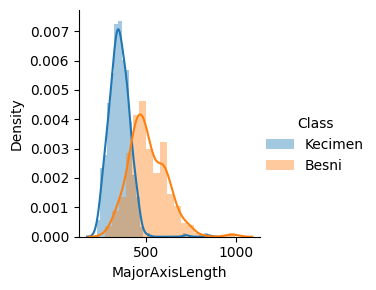

The following is a box_plot for the feature: MajorAxisLength


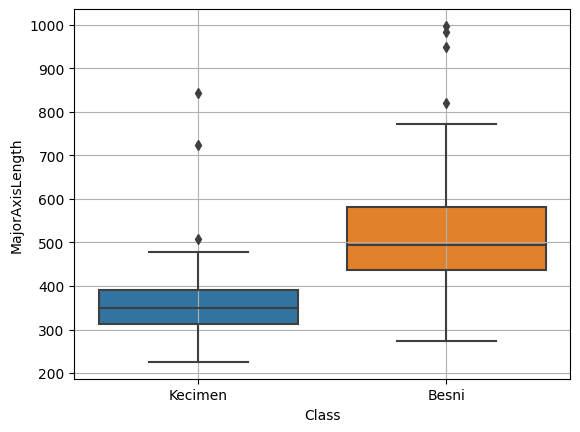

The following is a violin plot for the feature: MajorAxisLength


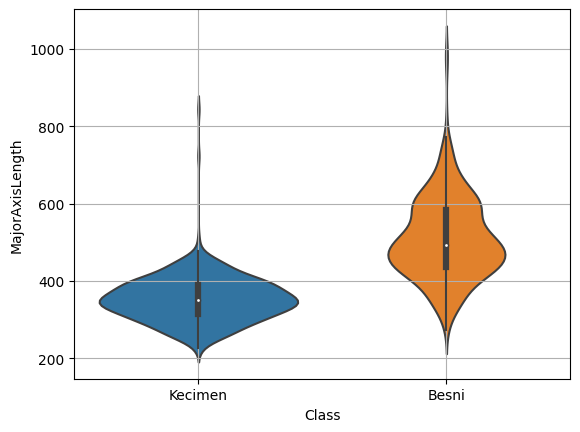

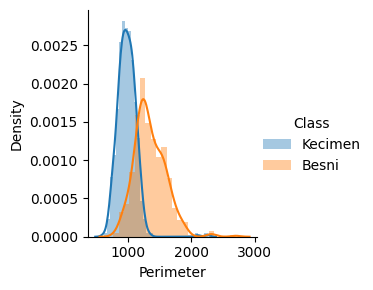

The following is a box_plot for the feature: Perimeter


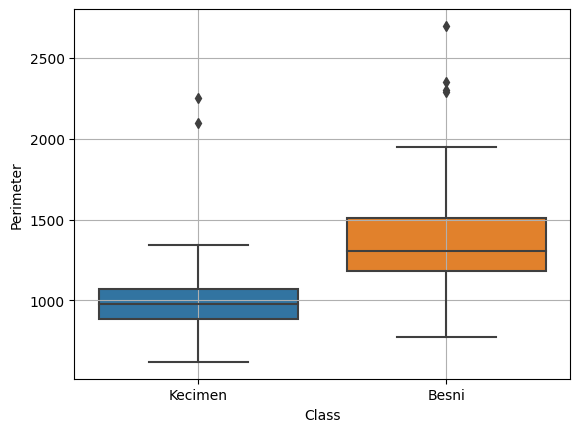

The following is a violin plot for the feature: Perimeter


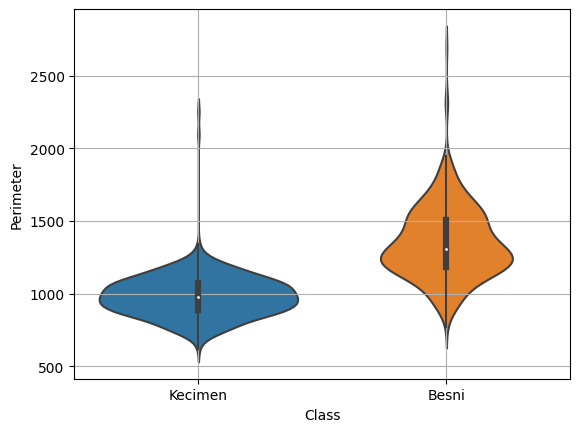

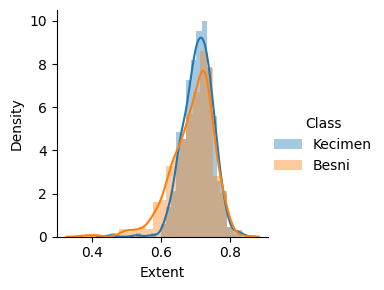

The following is a box_plot for the feature: Extent


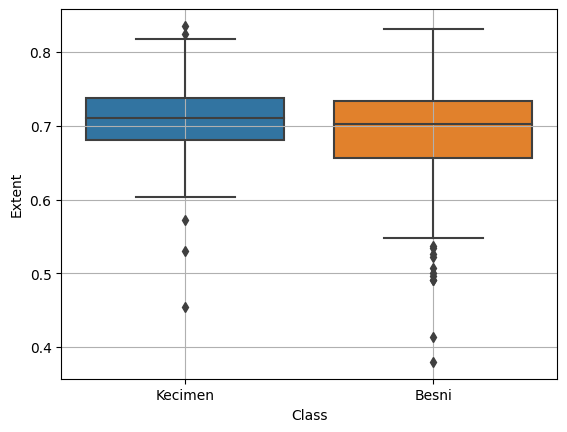

The following is a violin plot for the feature: Extent


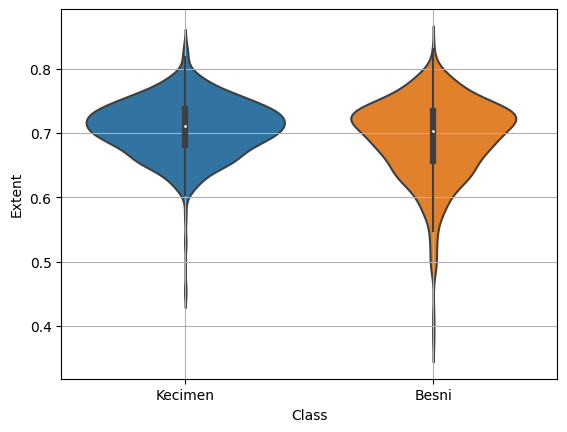

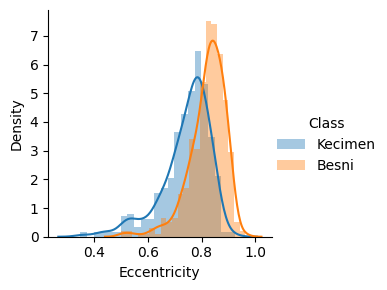

The following is a box_plot for the feature: Eccentricity


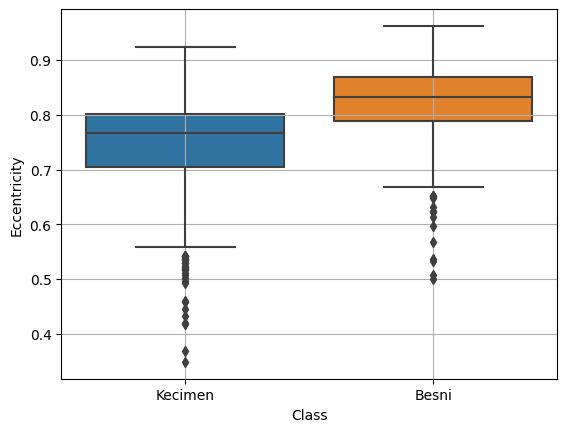

The following is a violin plot for the feature: Eccentricity


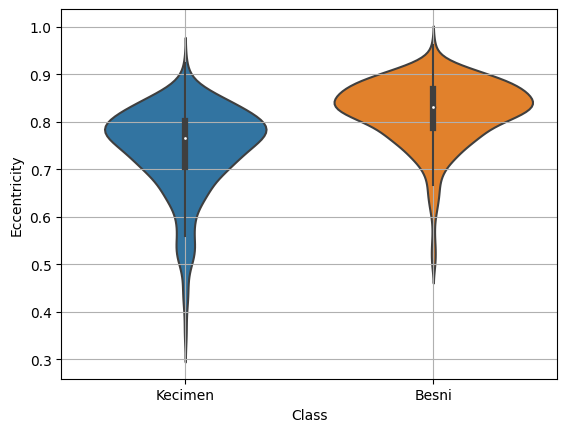

For the pair-plot-1, Class could be classified the most with an accuracy of 0.8977777777777778 by considering the two features: Perimeter and MajorAxisLength
For the pair-plot-2, Class could be classified the most with an accuracy of 0.9133333333333333 by considering the two features: MajorAxisLength and Extent
For the pair-plot-3, Class could be classified the most with an accuracy of 0.8733333333333333 by considering the two features: Eccentricity and MajorAxisLength
For the pair-plot-4, Class could be classified the most with an accuracy of 0.9044444444444445 by considering the two features: Perimeter and Extent
For the pair-plot-5, Class could be classified the most with an accuracy of 0.8822222222222222 by considering the two features: Eccentricity and Perimeter
For the pair-plot-6, Area could be classified the most with an accuracy of 0.7555555555555555 by considering the two features: Eccentricity and Extent


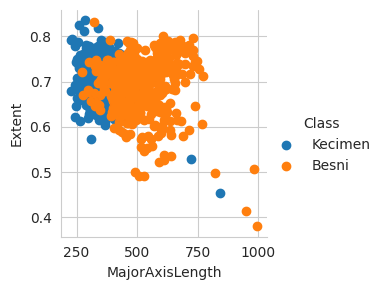

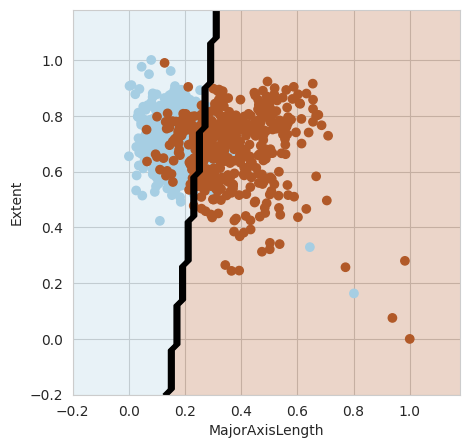

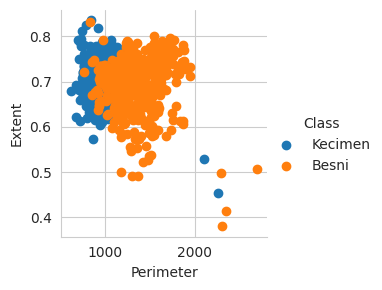

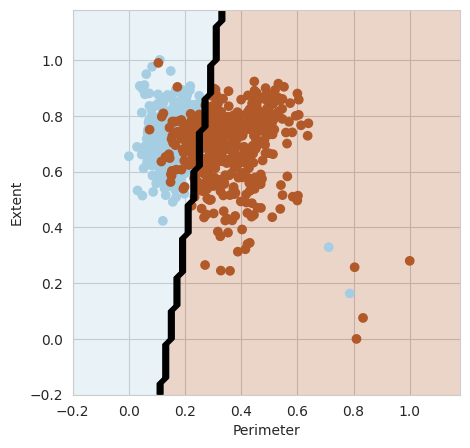

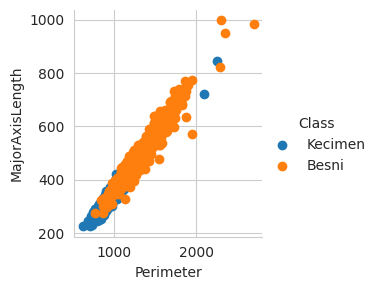

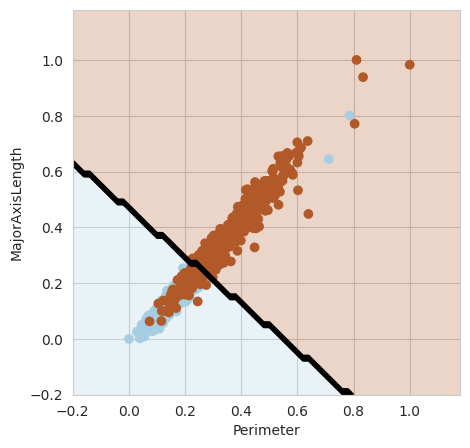

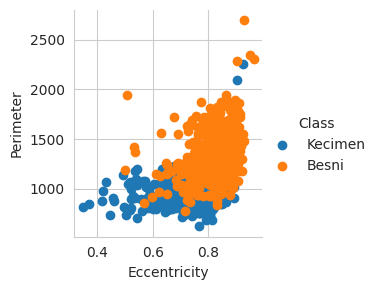

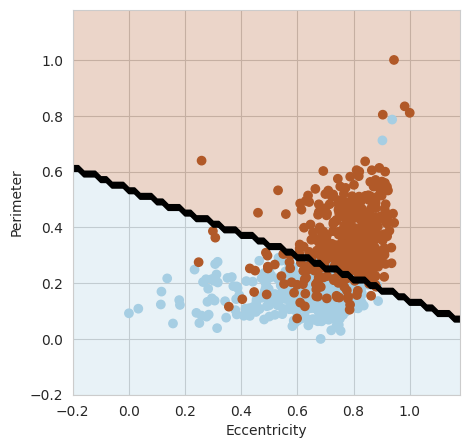

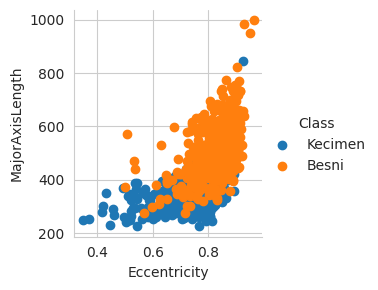

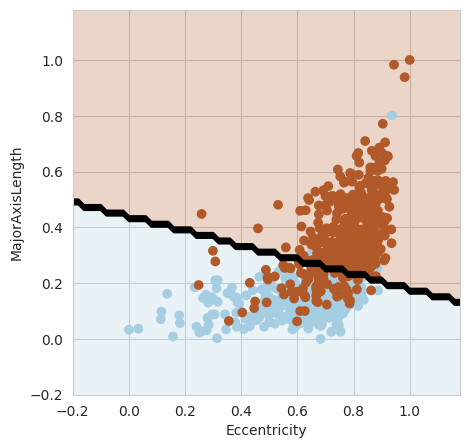

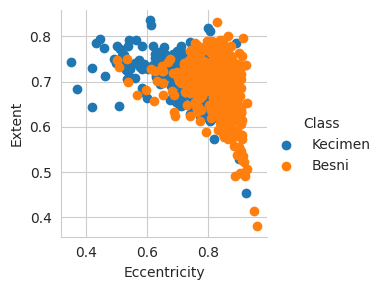

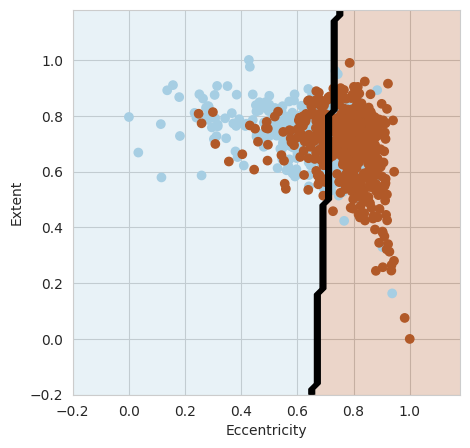

The following is a joint distribution plot for the two features: Perimeter and MajorAxisLength


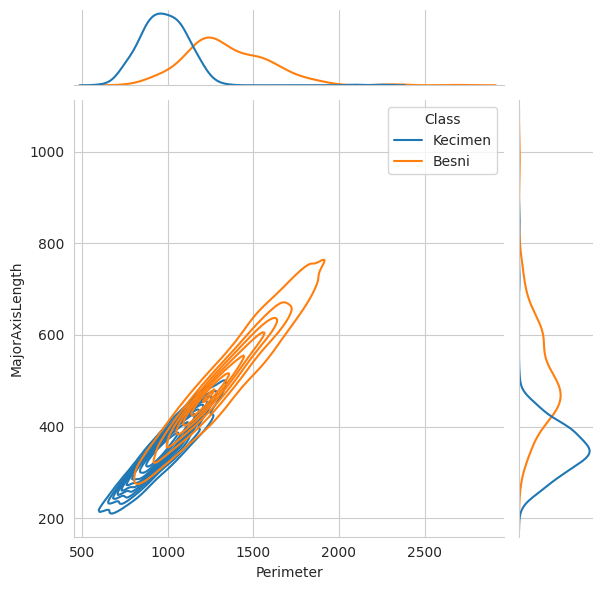

The following is a joint distribution plot for the two features: MajorAxisLength and Extent


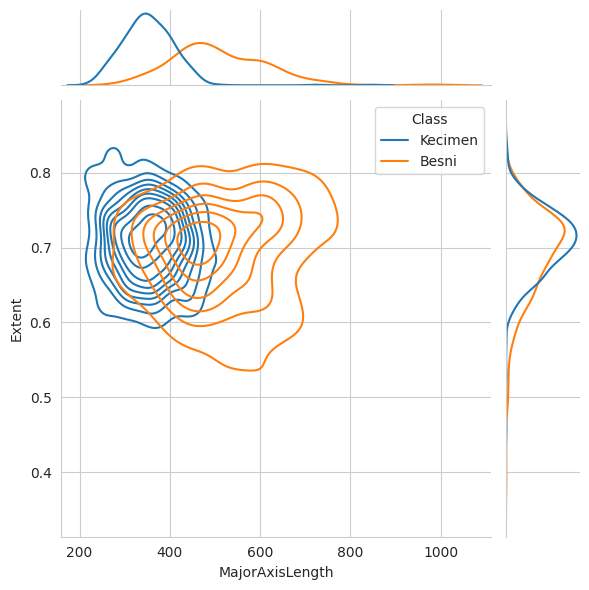

The following is a joint distribution plot for the two features: Eccentricity and MajorAxisLength


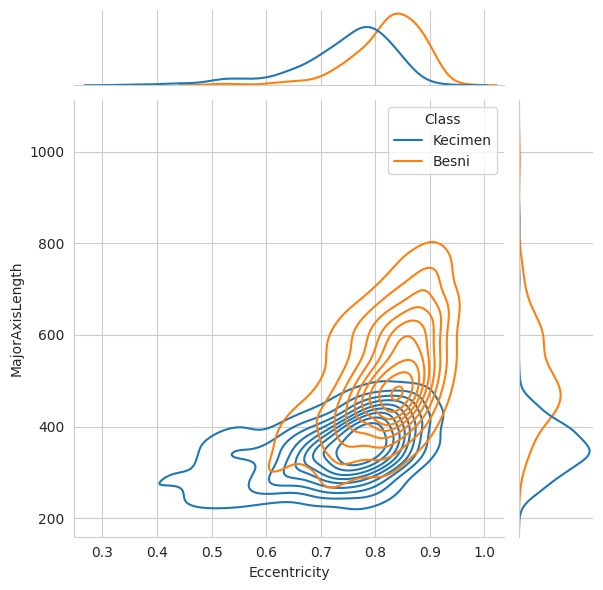

The following is a joint distribution plot for the two features: Perimeter and Extent


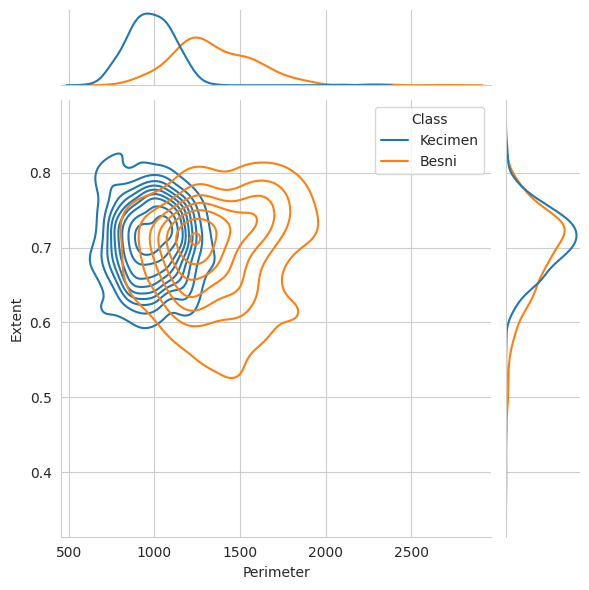

The following is a joint distribution plot for the two features: Eccentricity and Perimeter


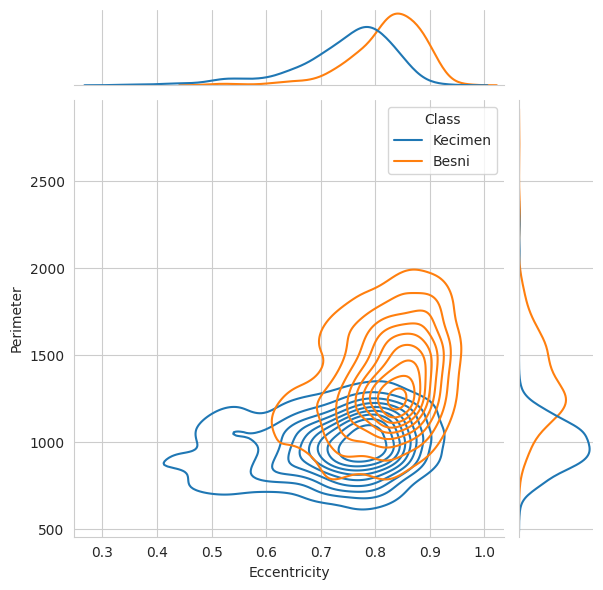

The following is a joint distribution plot for the two features: Eccentricity and Extent


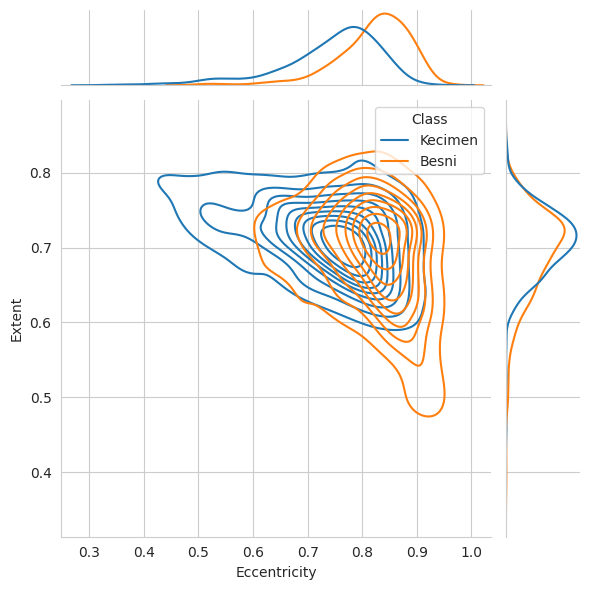

The following is a 3d scatter plot for the features: Perimeter, MajorAxisLength and Extent


The following is a 3d scatter plot for the features: Eccentricity, Perimeter and MajorAxisLength


The following is a 3d scatter plot for the features: Eccentricity, MajorAxisLength and Extent


The following is a 3d scatter plot for the features: Eccentricity, Perimeter and Extent


In [18]:
def classifiable_column(df, class_col):
    val_counts = df[class_col].value_counts()
    if len(val_counts)>0.5*len(df):
        return 0
    return 1

def regressible_column(df, target_col):
    t = type(df[target_col].iloc[0])
    if t==str:
        return 0
    return 1

def generate_report(report):
    pages = []
    temp = []
    for i in report:
        if i == 'flag':
            pages.append(temp)
            temp = []
        else:
            temp = temp+[i]
    total_pages = 0
    for i in pages:
        if len(i)!=0:
            total_pages+=1
    count = 0
    for i in pages:
        if len(i)>0:
            count += 1
            s = f'Page_{count}.html'
            f = open(s, "w")
            f.write(f'<html><head><title>{s}</title></head><body>')
            f.write('\n'.join(i))
            if count+1<=total_pages:
                f.write('<div style="text-align:right">')
                f.write(f"<a href='./Page_{count+1}.html'>Next</a></div>")
            if count-1>0:
                f.write('<div style="text-align:left">')
                f.write(f"<a href='./Page_{count-1}.html'>Previous</a></div>")
            f.write('</body></html>')

def main():
    while(1):
        try:
            task_nature = int(input("Please select the nature of task for a dedicated analysis:\n1. Classification\n2. Regression\n3. Clustering\n\t\t(1/2/3/4):"))
            break
        except:
            print("\nplease input either 1 or 2 or 3")
            continue
    #task_nature = 1#overridden for simplicity
    task = {1: 'classification', 2: 'regression', 3: 'clustering'}[task_nature]
    if task=='classification':
        class_col = str(input('Please enter a valid column for classification: '))
        while(1):
            if (class_col not in df.columns) or not(classifiable_column(df, class_col)):
                class_col = str(input('The entered column is invalid. \nPlease enter a valid column for classification: '))
            else:
                classification(df, class_col)
                break
    elif task=='regression':
        target_col = str(input('Please enter a valid column for regression: '))
        while(1):
            if (target_col not in df.columns) or not(regressible_column(df, target_col)):
                target_col = str(input('The entered column is invalid. \nPlease enter a valid column for regression: '))
            else:
                regression(df, target_col)
                break
    elif task=='clustering':
        clustering(df)

    # generate_report(report)
    # os.mkdir('result')
    # os.system('mv *.png *.html result')
main()

The following are the list of important features : 
ConvexArea
Extent
Class
Perimeter
The following is a histogram plot for the feature ConvexArea


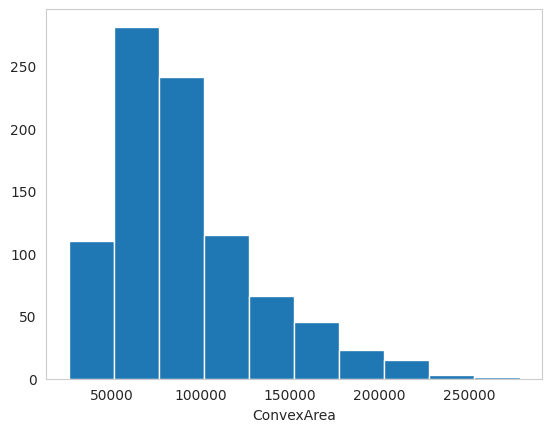

The following is a scatter plot between the features: ConvexArea and Area


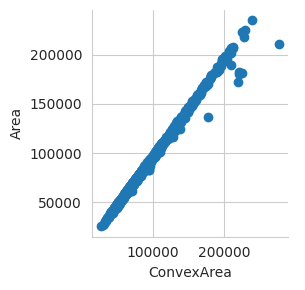

The following is a histogram plot for the feature Extent


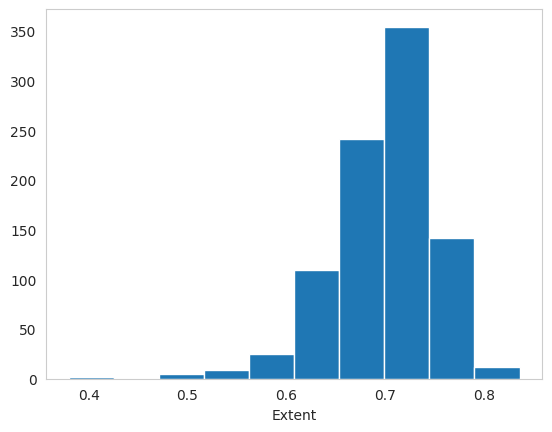

The following is a scatter plot between the features: Extent and Area


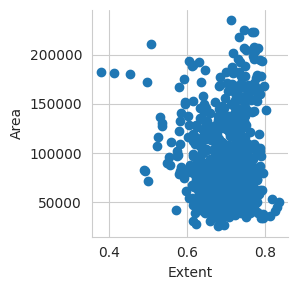

The following is a histogram plot for the feature Class


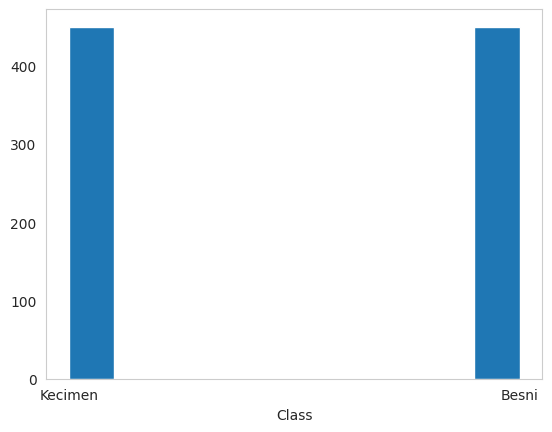

The following is a pie-chart for the feature Class


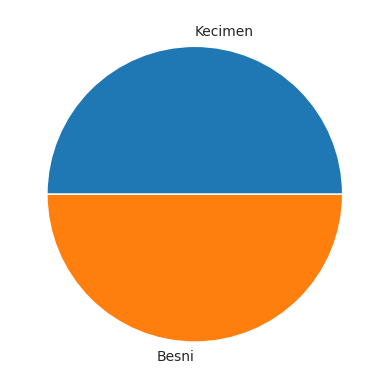

The following is a scatter plot between the features: Class and Area


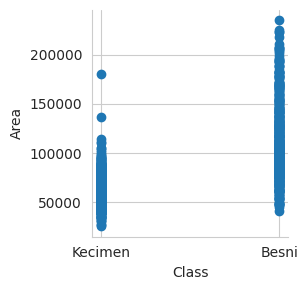

The following is a histogram plot for the feature Perimeter


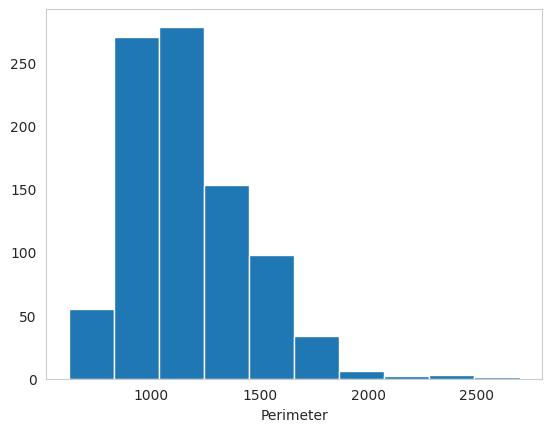

The following is a scatter plot between the features: Perimeter and Area


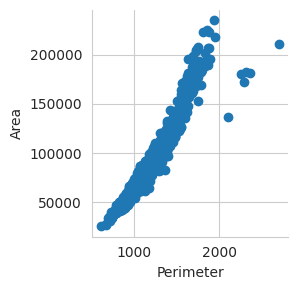

The following is a 3d scatter plot for the features : ConvexArea, Extent, and Area


The following is a 3d scatter plot for the features : ConvexArea, Class, and Area


The following is a 3d scatter plot for the features : ConvexArea, Perimeter, and Area


The following is a 3d scatter plot for the features : Class, Extent, and Area


The following is a 3d scatter plot for the features : Perimeter, Extent, and Area


The following is a 3d scatter plot for the features : Perimeter, Class, and Area


In [19]:
regression(df, 'Area')

The given dataset is a balanced dataset


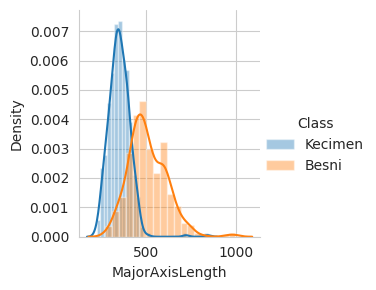

The following is a box_plot for the feature: MajorAxisLength


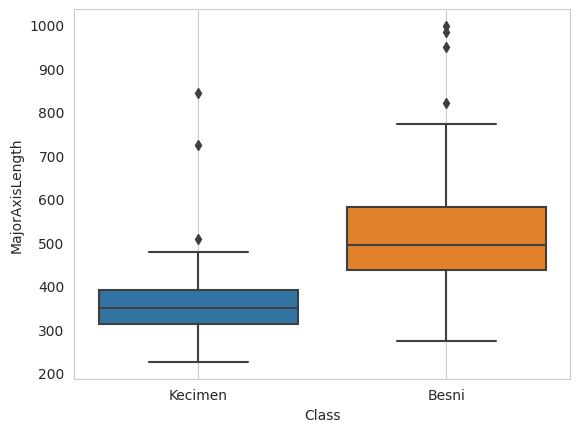

The following is a violin plot for the feature: MajorAxisLength


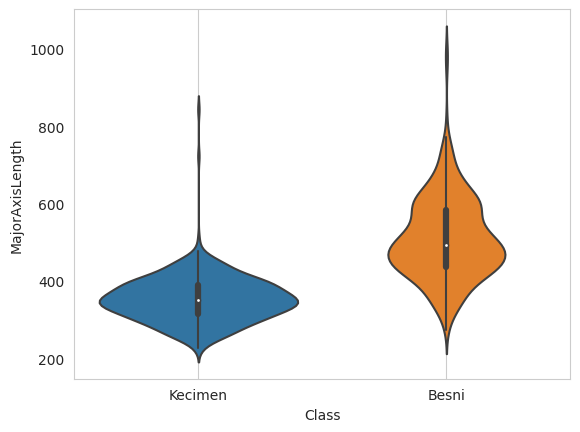

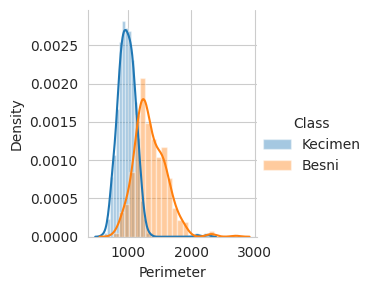

The following is a box_plot for the feature: Perimeter


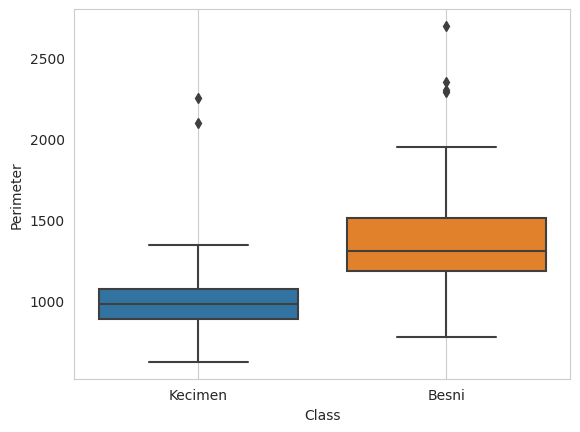

The following is a violin plot for the feature: Perimeter


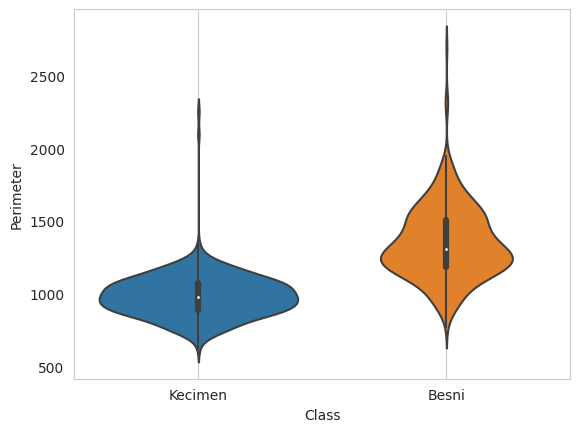

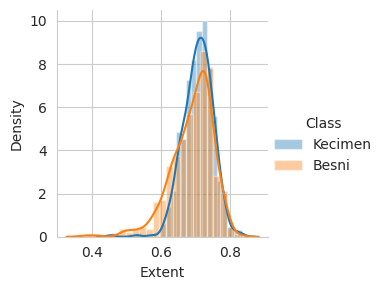

The following is a box_plot for the feature: Extent


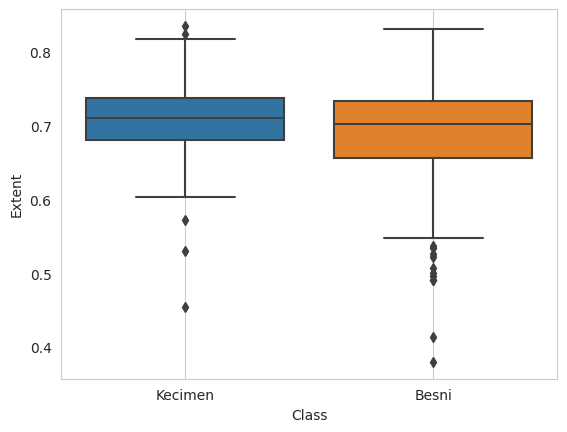

The following is a violin plot for the feature: Extent


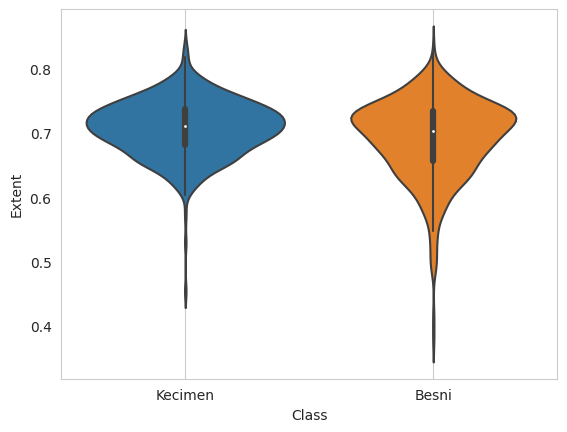

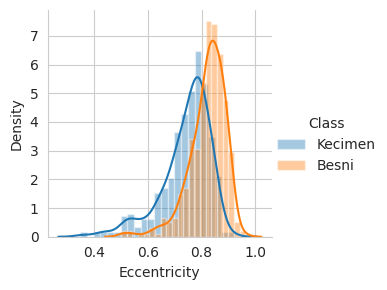

The following is a box_plot for the feature: Eccentricity


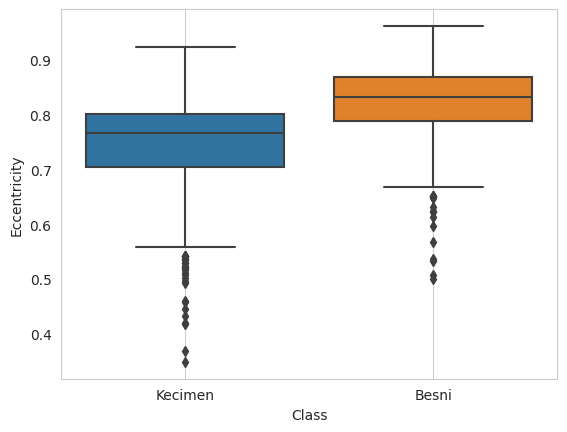

The following is a violin plot for the feature: Eccentricity


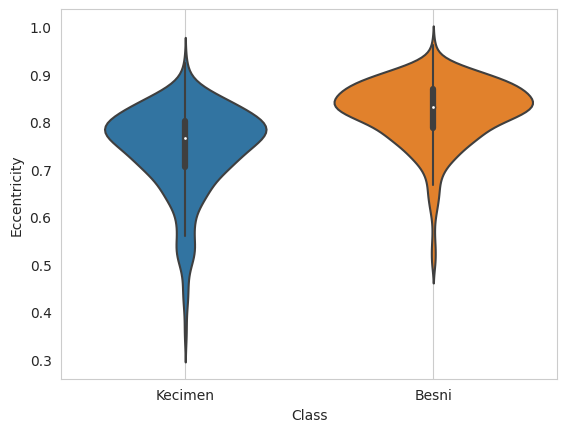

For the pair-plot-1, Class could be classified the most with an accuracy of 0.8977777777777778 by considering the two features: Perimeter and MajorAxisLength
For the pair-plot-2, Class could be classified the most with an accuracy of 0.9133333333333333 by considering the two features: MajorAxisLength and Extent
For the pair-plot-3, Class could be classified the most with an accuracy of 0.8733333333333333 by considering the two features: Eccentricity and MajorAxisLength
For the pair-plot-4, Class could be classified the most with an accuracy of 0.9044444444444445 by considering the two features: Perimeter and Extent
For the pair-plot-5, Class could be classified the most with an accuracy of 0.8822222222222222 by considering the two features: Eccentricity and Perimeter
For the pair-plot-6, Area could be classified the most with an accuracy of 0.7555555555555555 by considering the two features: Eccentricity and Extent


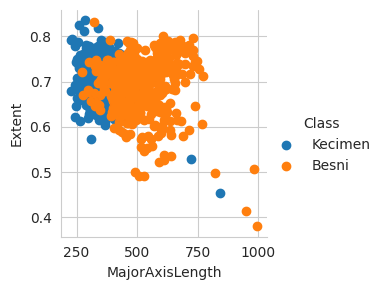

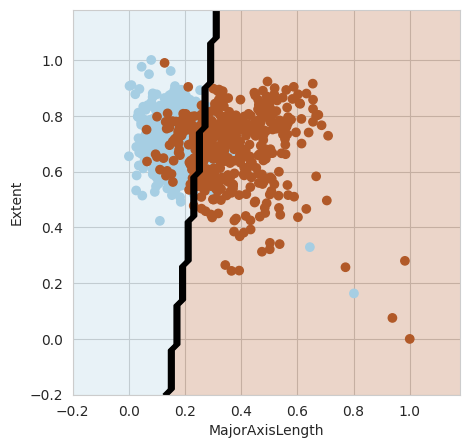

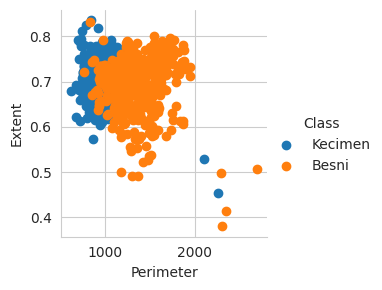

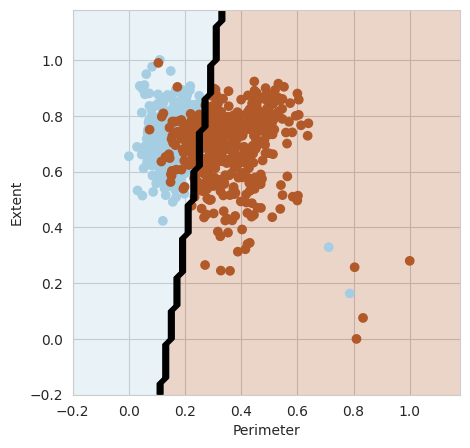

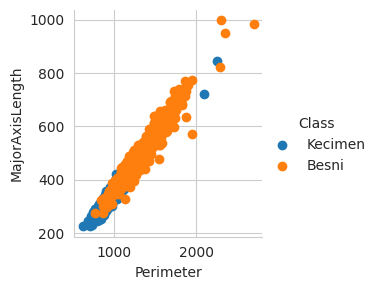

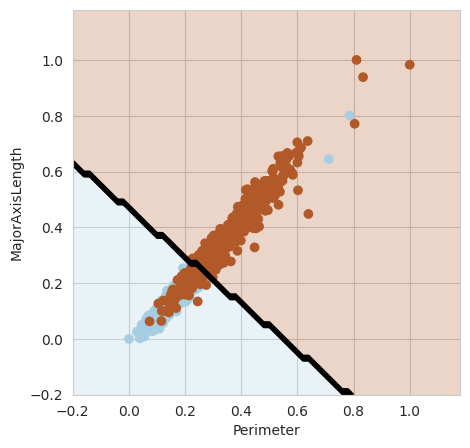

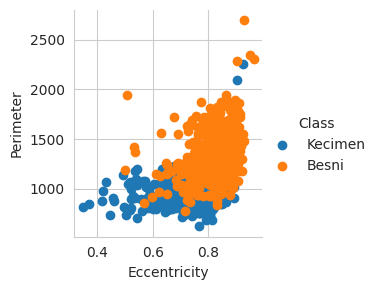

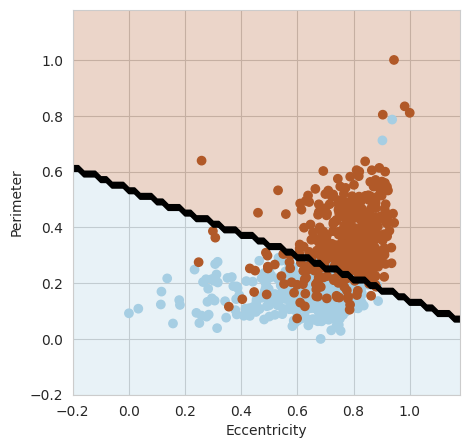

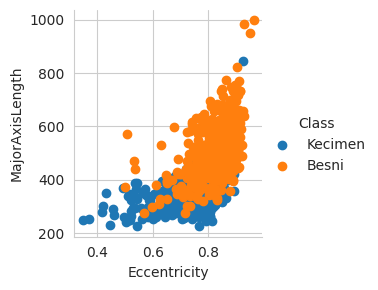

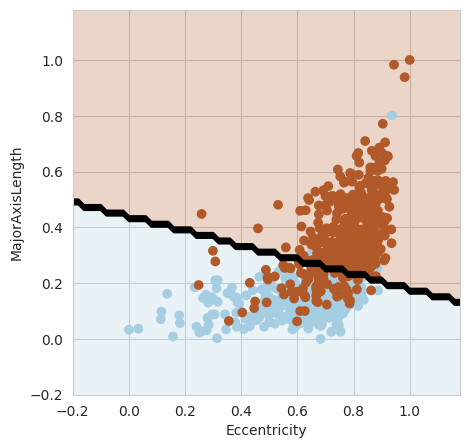

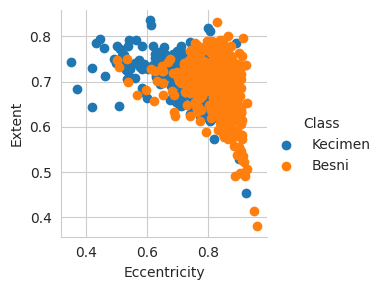

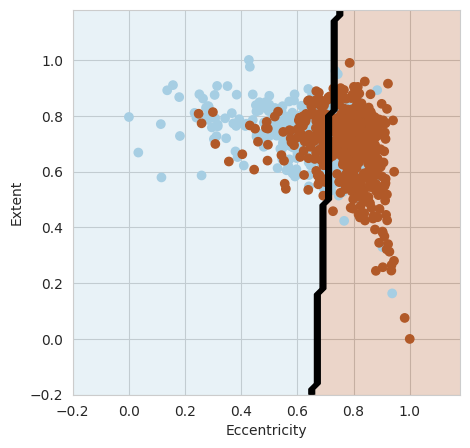

The following is a joint distribution plot for the two features: Perimeter and MajorAxisLength


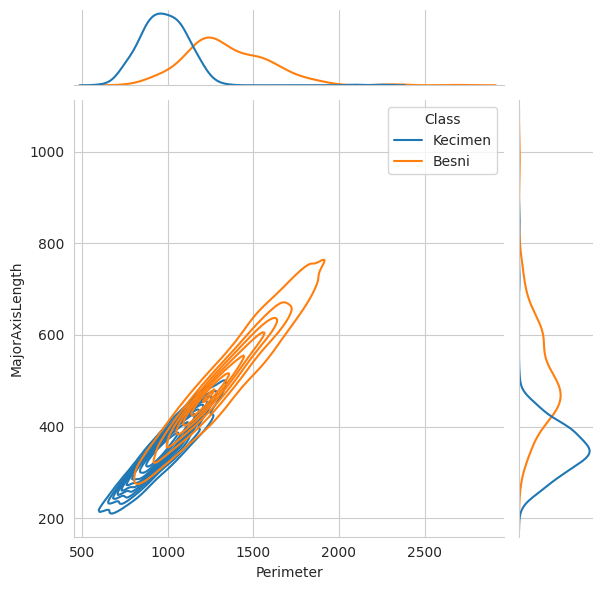

The following is a joint distribution plot for the two features: MajorAxisLength and Extent


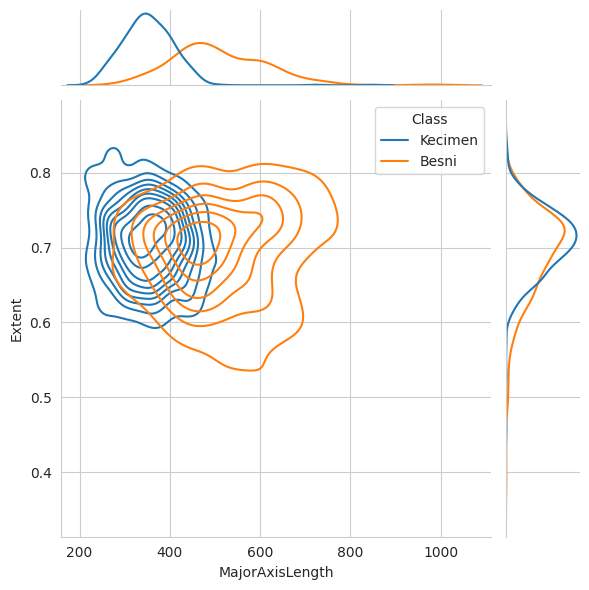

The following is a joint distribution plot for the two features: Eccentricity and MajorAxisLength


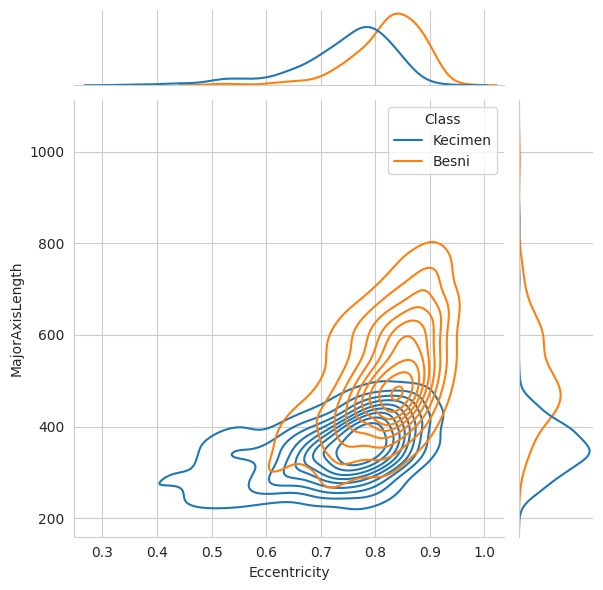

The following is a joint distribution plot for the two features: Perimeter and Extent


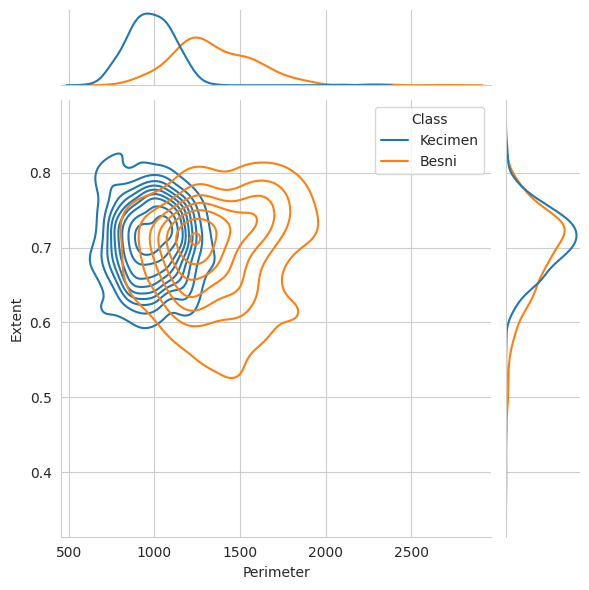

The following is a joint distribution plot for the two features: Eccentricity and Perimeter


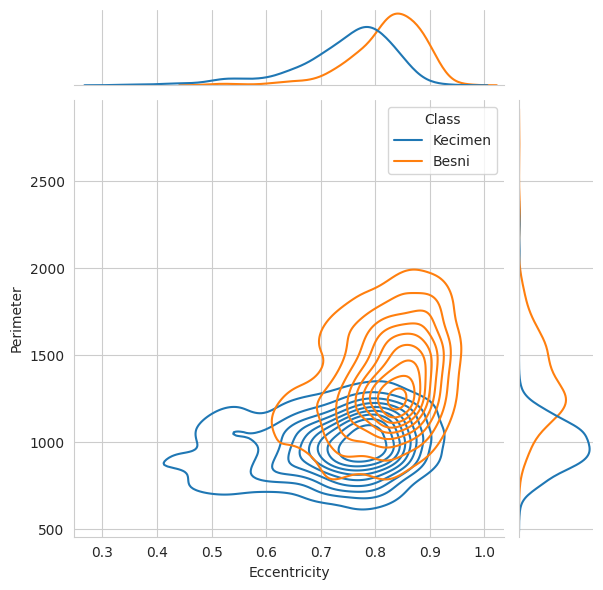

The following is a joint distribution plot for the two features: Eccentricity and Extent


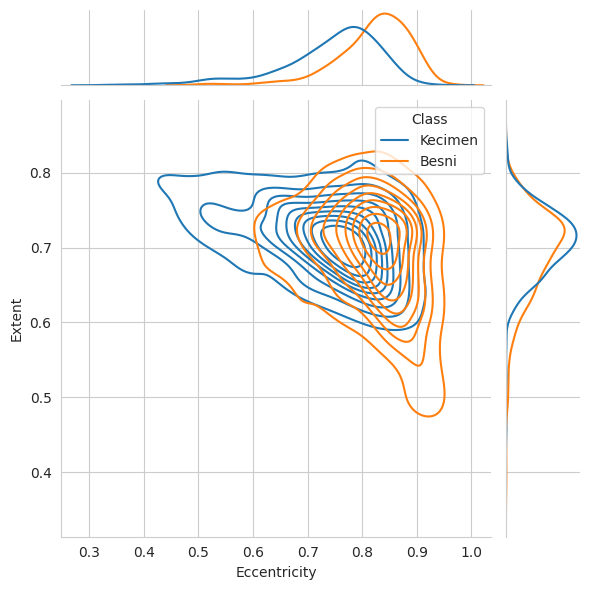

The following is a 3d scatter plot for the features: Perimeter, MajorAxisLength and Extent


The following is a 3d scatter plot for the features: Eccentricity, Perimeter and MajorAxisLength


The following is a 3d scatter plot for the features: Eccentricity, MajorAxisLength and Extent


The following is a 3d scatter plot for the features: Eccentricity, Perimeter and Extent


The following represents use of Principal component Analysis dimensionality reduction approach to determine the groupings in the given dataset by projecting the data to one dimension


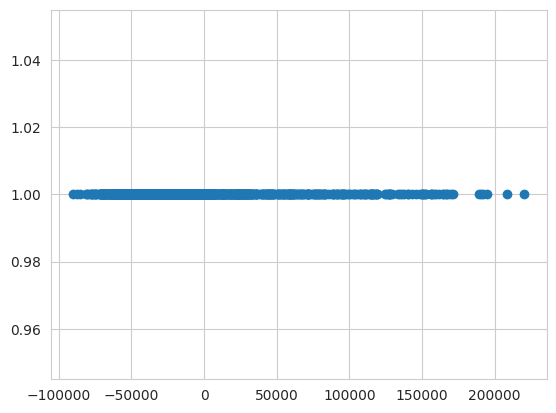

The following represents use of t-SNE dimensionality reduction to determine the groupings in the given dataset by projecting the data to one dimension


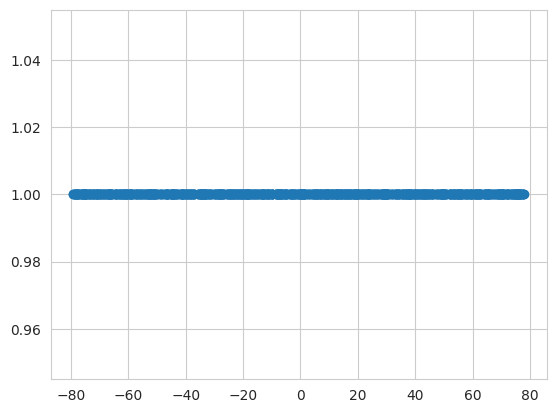

The following represents use of Principal component Analysis dimensionality reduction to determine the groupings in the given dataset by projecting the data to two dimensions


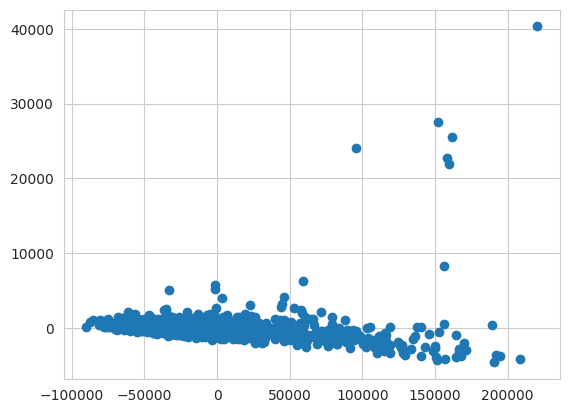

The following represents use of t-SNE dimensionality reduction to determine the groupings in the given dataset by projecting the data in two dimensions


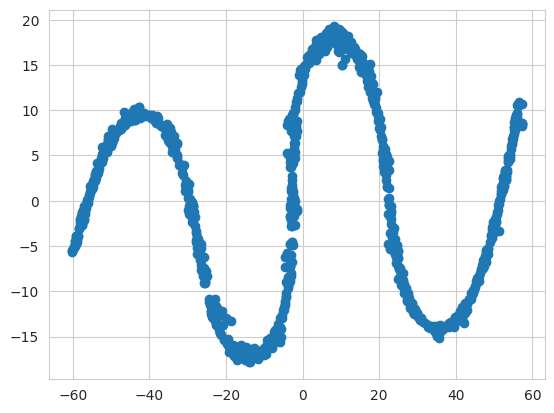

The following represents use of Principal component Analysis dimensionality reduction to determine the groupings in the given dataset by projecting the data to three dimensions


The following represents use of t-SNE dimensionality reduction to determine the groupings in the given dataset by projecting the data to three dimensions


In [20]:
clustering(df)